*This is code to test the functionality of LSTM. If this code is messy, sorry in advance... this is my third or second time dealing with Pytorch...*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from collections import OrderedDict
import os
import json
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import dask.dataframe as dd
import pandas as pd


cuda = torch.cuda.is_available()
# torch.manual_seed(1)

# Parameter setting.

In [2]:
#manual setting for parameters
cwd = os.getcwd()
specpath = cwd + '/safekit/features/specs/lm/'
datapath = cwd + '/data_examples/lanl/lm_feats/'
layer_list = [10] #hidden units of each layer.
lr = 1e-3 #learning rate .
embedding_dim = 20 # one word/char will be mapped to this dimension.
mb_size = 128 #size of mini batch.
maxbadcount = 10
patience = 20
test = False
delimiter = ' '
direction = 'fwd' 
token_level = 'word'
tiered = False

In [3]:
if token_level == 'word':
    datafolder = datapath + 'word_day_split/'
    config = 'lanl_word_config.json'
    jagged = False
else:
    datafolder = datapath + 'raw_day_split/'
    config = 'lanl_char_config.json'
    jagged = True

if direction == 'fwd':
    bid = False
else: 
    bid = True

if direction == 'fwd' and token_level == 'word':
    skipsos = True
else:
    skipsos = False

conf = json.load(open(specpath + config, 'r'))

In [4]:
vocab_size = conf['token_set_size']  
weekend_days = conf["weekend_days"]
sentence_length = conf['sentence_length'] - 1 - int(skipsos) + int(bid)
if test:
    files = conf["test_files"] # 5000 lines from day 2
else:
    files = conf["train_files"] + conf["test_files"] # 5000 lines from each of day 0, day 1 and day 2
    # files = [str(i) + '.txt' for i in range(conf["num_days"]) if i not in weekend_days]

# Class: Early Stopping

In [5]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter % 10 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}. Best loss: {-self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Class: Dataset handler

In [6]:
def get_mask(lens, num_tokens):
    """
    For masking output of lm_rnn for jagged sequences for correct gradient update.
    Sequence length of 0 will output nan for that row of mask so don't do this.

    :param lens: Numpy vector of sequence lengths
    :param num_tokens: (int) Number of predicted tokens in sentence.
    :return: A numpy array mask MB X num_tokens
             For each row there are: lens[i] values of 1/lens[i]
                                     followed by num_tokens - lens[i] zeros
    """
    mask_template = torch.arange(num_tokens, dtype=torch.float)
    return (mask_template < lens) / lens


In [7]:
class LazyTextDataset(Dataset):
    def __init__(self, filename, sentence_length, skipsos, jagged, bidir, delimiter, transform=None):
        self._filename = filename
        self._total_data = 0
        self.transform = transform
        self.f = open(filename, 'r')
        self._total_data = len(self.f.readlines()) - 1
        self.f = open(filename, 'r')
        
        self.delimiter = delimiter
        self.skipsos = skipsos
        self.jagged = jagged
        self.bidir = bidir
        self.sentence_length = sentence_length
       

    def __getitem__(self, idx):
        l = self.f.readline()
        sentence_length = self.sentence_length - 1 - int(self.skipsos) + int(self.bidir)
        if l != '':
            line = torch.tensor([int(k) for k in l.strip().split(self.delimiter)])
            self.endx = len(line) - int(not self.bidir)
            self.endt = len(line) - int(self.bidir)

            self.datadict = {'line': line[0],
                            'second': line[1],
                            'day': line[2],
                            'user': line[3],
                            'red': line[4],
                            'x': line[(5 + int(self.jagged) + int(self.skipsos)):self.endx],
                            't': line[(6 + int(self.jagged) + int(self.skipsos)):self.endt]}
            if self.jagged:
                self.datadict['length'] = line[5]
                self.datadict['mask'] = get_mask(self.datadict['length'] - 2*int(self.bidir) - int(self.skipsos), self.sentence_length - 2*int(self.bidir))
                # assert np.all(self.datadict['lengths'] <= x.get_shape().as_list()[1]), 'Sequence found greater than num_tokens_predicted'
                # assert np.nonzero(self.datadict['lengths'])[0].shape[0] == self.datadict['lengths'].shape[0], \
                #     'Sequence lengths must be greater than zero.' \
                #     'Found zero length sequence in datadict["lengths"]: %s' % self.datadict['lengths']  

        return self.datadict
    
    def __len__(self):
        return self._total_data

# Data handler for a tiered model

In [8]:
class OnlineLMBatcher: 
    # It seems Pytorch dataset and dataloader can't sort users... so I needed to build it from scratch..
    def __init__(self, file_path, conf, context_size, skipsos, jagged, bidir, batch_size=100, num_steps=5, delimiter=" ", skiprows=0):
        cols = ['line', 'second', 'day', 'user', 'red'] + [f'x_{i}' for i in range(conf['sentence_length'])]
        self.day_df = dd.read_csv(file_path, names=cols, sep = ' ', blocksize=25e3)
        self.user_id = [] # set()
        self.lst_avail_id = []
        self.pre_lst_avail_id = []
        self.df_id = {}
        self.len_id = {}
        self.saved_lstm = {}
        self.context_size = context_size
        self.sel_part = 0
        self.current_num_batch = 0
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.staggler_num_steps = 1
        self.jagged = jagged
        self.skipsos = skipsos
        self.bidir = bidir
        self.sentence_length = (conf['sentence_length'] - 1) - int(self.skipsos) + int(self.bidir)
        self.empty = False
        
    def filter_partition(self):
        partition = self.day_df.get_partition(self.sel_part)
        current_ids = partition.user.drop_duplicates().compute().tolist()
        for c_id in current_ids:
            if c_id not in self.user_id:
                self.df_id[c_id] = None
                self.saved_lstm[c_id] = (torch.zeros((self.context_size[0])),\
                                         torch.zeros((len(self.context_size), self.context_size[0])),\
                                         torch.zeros((len(self.context_size), self.context_size[0])))
            self.df_id[c_id] = pd.concat([self.df_id[c_id], partition[partition.user == c_id].compute()], axis=0)
            self.len_id[c_id] = len(self.df_id[c_id])

        self.user_id = current_ids + [usr for usr in self.user_id if usr not in current_ids]
        self.sel_part += 1   

    def update_len(self):
        self.lst_avail_id = []
        self.current_num_batch = 0
        for j in self.user_id:
            above_num_steps = self.len_id[j] >= self.num_steps
            self.current_num_batch += above_num_steps
            if above_num_steps and j not in self.lst_avail_id:
                self.lst_avail_id.append(j)
    
    def __iter__(self):
        while not self.empty:
            output = []
            datadict = {}
            ctxt_vector = torch.tensor([])
            h_state = torch.tensor([])
            c_state = torch.tensor([])
            while output == []:
                if self.current_num_batch < self.batch_size and self.sel_part < self.day_df.npartitions: # Read a new partition
                    self.filter_partition()
                    self.update_len()
                elif self.current_num_batch == 0 and self.sel_part == self.day_df.npartitions: # Activate staggler mode
                    self.batch_size = self.batch_size * self.num_steps
                    self.num_steps = self.staggler_num_steps
                    self.sel_part += 1
                    self.update_len()
                elif self.current_num_batch > 0: # Output data
                    for j in self.lst_avail_id[:self.batch_size]:
                        output.append(self.df_id[j].iloc[0:self.num_steps].values)                    
                        ctxt_vector = torch.cat((ctxt_vector, torch.unsqueeze(self.saved_lstm[j][0], dim = 0)), dim = 0)                    
                        h_state = torch.cat((h_state, torch.unsqueeze(self.saved_lstm[j][1], dim = 0)), dim = 0)
                        c_state = torch.cat((c_state, torch.unsqueeze(self.saved_lstm[j][2], dim = 0)), dim = 0)
                        self.df_id[j] = self.df_id[j].iloc[self.num_steps:, :]
                        self.len_id[j] = len(self.df_id[j])
                    self.pre_lst_avail_id = self.lst_avail_id
                    self.update_len()
                    output = torch.tensor(output).long()
                    batch = torch.transpose(output, 0, 1)
                    endx = batch.shape[2] - int(not self.bidir)
                    endt = batch.shape[2] - int(self.bidir)
                    datadict = {'line': batch[:, :, 0],
                                'second': batch[:, :, 1],
                                'day': batch[:, :, 2],
                                'user': batch[:, :, 3],
                                'red': batch[:, :, 4],
                                'x': [batch[0, :, 5 + self.jagged + self.skipsos:endx]] * self.num_steps,
                                't': [batch[0, :, 6 + self.jagged + self.skipsos:endt]] * self.num_steps,
                                'context_vector': ctxt_vector, #,['context_vector'],
                                'c_state_init': torch.transpose(h_state, 0,1), #state_triple['c_state_init'],
                                'h_state_init': torch.transpose(c_state, 0,1)} #state_triple['h_state_init']}
                    if self.jagged:
                        datadict['lens'] = [batch[0, :, 5] - self.skipsos] * self.num_steps
                        datadict['masks'] = [get_mask(seq_length - 2 * self.bidir, sentence_length - 2 * self.bidir) for
                                             seq_length in datadict['lens']]
                else: # Empty dataset.
                    self.empty = True
                    break

            yield datadict
    
    def update_state(self, ctxt_vectors, h_states, c_states):
        ctxt_vectors = ctxt_vectors.data
        h_states = torch.transpose(h_states.data, 0,1)
        c_states = torch.transpose(c_states.data, 0,1)
        for usr, ctxt_v, h_state, c_state in zip(self.pre_lst_avail_id[:self.batch_size], ctxt_vectors, h_states, c_states):
            self.saved_lstm[usr] = (ctxt_v, h_state, c_state) 

In [9]:
context_size = [10]
num_steps = 3
data_handler = OnlineLMBatcher(datafolder + files[0], conf, context_size, skipsos, jagged, bid, batch_size=64, num_steps=num_steps, delimiter=" ", skiprows=0)


In [10]:
for i, data in enumerate(data_handler):
    print(data['line'])
    if i == 3:
        break

tensor([[ 217,  227,  230,  113,  146,  147,  149,  156,  161, 1538,  166,  167,
          183,  186, 2496,  187,  193,  202,  205,  242, 2510, 1548,  181,  184,
         2640,  111, 2096, 1542,  189, 2660,  221, 1621, 2731,  724, 2740, 2741,
         2139,  803, 2150, 1500,  747,  764, 2858,  121,  150,  784,  177,  117,
         2973,  126,  729,  832,  833,  841,  752,  797, 2088,  725, 1550, 3198,
         3288, 2122, 3396, 1507],
        [ 218,  228,  231,  114,  732,  148,  742,  157,  759, 1539,  762,  168,
          794,  800, 2497,  188,  194, 2505,  206,  243, 2511, 1549,  182,  185,
         2728,  112, 2097, 2110,  190, 2661,  222, 1622, 2732, 2093, 2806, 2808,
         2745, 2295, 2151, 2790,  748,  765, 2859,  122,  151,  785,  178,  118,
         2974,  127, 2979, 3003,  834, 2160,  753,  798, 3136, 2383, 2283, 3199,
         3289, 2123, 3397, 2388],
        [ 824,  229,  232,  717,  733,  741, 2101,  158, 2483, 1540,  763,  169,
          795,  801, 2498,  804,  195, 31

# Class: LSTM Models (To-do: tiered model)

In [11]:

def truncated_normal_(tensor, mean=0, std=1):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)
    return tensor    

def initialize_weights(net, initrange = 1.0):
    for m in net.modules():
        if isinstance(m, nn.Linear):
            initrange *= 1.0/np.sqrt(m.weight.data.shape[1])
            m.weight.data = initrange * truncated_normal_(m.weight.data, mean = 0.0, std =1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Embedding):
            truncated_normal_(m.weight.data, mean = 0.0, std =1)


class Fwd_LSTM(nn.Module):
    def __init__(self, layers, vocab_size, embedding_dim, jagged = False, tiered =False, context_vector_size = 0):
        super().__init__()
        self.layers = layers 
        self.jagged = jagged
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.tiered = tiered
        self.bid = False

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        if self.tiered:
            self.embedding_dim += context_vector_size  

#         self.stacked_lstm = build_stacked_lstm(self.layers, self.embedding_dim, self.bid)
        self.stacked_lstm = nn.LSTM(self.embedding_dim, self.layers[0], len(self.layers), batch_first = True, bidirectional = self.bid)
        self.tanh = nn.Tanh()
        self.hidden2tag = nn.Linear(self.layers[-1], self.vocab_size)

        initialize_weights(self)

    def forward(self, sequences, lengths = None, context_vectors = None):
        x_lookups = self.embeddings(sequences)  # batch x seq len x embedding
        if self.tiered:
            cat_x_lookups = torch.tensor([])
            x_lookups= x_lookups.transpose(0,1) #  seq len x batch x embedding
            for x_lookup in x_lookups: #for each batch x embedding.\
                x_lookup = torch.unsqueeze(torch.cat((x_lookup, context_vectors), dim=1), dim=0) # 1 x batch x embedding
                cat_x_lookups = torch.cat((cat_x_lookups, x_lookup), dim = 0) # concatenate so n x batch x embedding (n length of a concatenated sequence)
            x_lookups = cat_x_lookups.transpose(0,1) #batch x seq len x embedding + context 
            
        lstm_in = x_lookups
        if self.jagged:
            lstm_in = pack_padded_sequence(lstm_in, lengths, batch_first=True)
        lstm_out, (hx, cx)  = self.stacked_lstm(x_lookups)
        if self.jagged: 
            lstm_out = pad_packed_sequence(lstm_out, batch_first=True)

        output = self.tanh(lstm_out)
        tag_size = self.hidden2tag(output)
        return tag_size, lstm_out, hx
    
class Bid_LSTM(nn.Module):
    def __init__(self, layers, vocab_size, embedding_dim, jagged = False, tiered =False, context_vector_size = 0):
        super().__init__()
        
        self.layers = layers 
        self.jagged = jagged
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.tiered = tiered
        self.bid = True
        
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        if self.tiered:
            self.embedding_dim += context_vector_size

        self.stacked_bid_lstm = nn.LSTM(self.embedding_dim, self.layers[0], len(self.layers), batch_first = True, bidirectional = self.bid)
        self.tanh = nn.Tanh()
        self.hidden2tag = nn.Linear(self.layers[-1] * 2, self.vocab_size)

        initialize_weights(self)

    def forward(self, sequences, lengths = None, context_vectors = None):   
        x_lookups = self.embeddings(sequences) #batch size, sequence length, embedded dimension
        if self.tiered:
            x_lookups = torch.cat(x_lookups, context_vectors, dim=2)

        lstm_in = x_lookups
        if self.jagged:
            lstm_in = pack_padded_sequence(lstm_in, lengths, batch_first=True)            
            
        lstm_out, (hx, cx)  = self.stacked_bid_lstm(x_lookups)
        if self.jagged:
            lstm_out = pad_packed_sequence(lstm_out, batch_first=True)
        
        output = self.tanh(lstm_out)
        tag_size = self.hidden2tag(output)
           
        return tag_size, lstm_out, hx
    

class Context_LSTM(nn.Module):
    def __init__(self, ctxt_lv_layers, input_dim):
        super().__init__()
        
        self.ctxt_lv_layers = ctxt_lv_layers 
        self.input_dim = input_dim
        self.context_lstm_layers = nn.LSTM(self.input_dim, self.ctxt_lv_layers[0], len(ctxt_lv_layers), batch_first = True, bidirectional = bid)
        
        initialize_weights(self)

    def forward(self, lower_lv_outputs, final_hidden, context_h, context_c, seq_len = None):   
        if seq_len is not None:
            mean_hidden = torch.sum(lower_lv_outputs, dim = 1) / seq_len
        else:
            mean_hidden = torch.mean(lower_lv_outputs, dim = 1)
        cat_input = torch.cat((mean_hidden, final_hidden[-1]), dim=1)
        synthetic_input = torch.unsqueeze(cat_input, dim = 1)

        output, (context_hx, context_cx) = self.context_lstm_layers(synthetic_input, (context_h, context_c))
        return output, context_hx, context_cx 
    
class Tiered_LSTM(nn.Module):
    def __init__(self, low_lv_layers, ctxt_lv_layers, vocab_size, embedding_dim, context_vector_size, 
                 jagged = False, bid = False):
        
        super().__init__()
        self.bid = bid
        if self.bid:
            self.model = Bid_LSTM
        else:
            self.model = Fwd_LSTM
        self.low_lv_layers = low_lv_layers 
        self.ctxt_lv_layers = ctxt_lv_layers
        self.jagged = jagged
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.low_lv_lstm = self.model(self.low_lv_layers, self.vocab_size, self.embedding_dim, 
                                      jagged = self.jagged, tiered = True, context_vector_size = self.ctxt_lv_layers[-1])
        self.ctxt_lv_lstm = Context_LSTM(self.ctxt_lv_layers, low_lv_layers[-1] * 2)

        initialize_weights(self)

    def forward(self, user_sequences, context_vectors, context_h, context_c, lengths = None):
        self.ctxt_vector = context_vectors
        self.ctxt_h = context_h
        self.ctxt_c = context_c
        tag_output = []
        for sequences in user_sequences: #number of steps (e.g., 3), number of users (e.g., 64), lengths of sequences (e.g., 10)
            tag_size, low_lv_lstm_outputs, final_hidden = self.low_lv_lstm(sequences, lengths = lengths, context_vectors = self.ctxt_vector)
            self.ctxt_vector, self.ctxt_h, self.ctxt_c = self.ctxt_lv_lstm(low_lv_lstm_outputs, final_hidden, self.ctxt_h, self.ctxt_c, seq_len = lengths)
            tag_output.append(tag_size)
            self.ctxt_vector = torch.squeeze(self.ctxt_vector, dim = 1)
        return tag_output, self.ctxt_vector, self.ctxt_h, self.ctxt_c

# Function: Train and evaluate LSTM models

In [12]:
def train_model(model, criterion, optimizer, scheduler, early_stopping, dataloader, cuda, jagged, epochs=1):
    
    train_losses = []

    flag = False
    for i in range(epochs):
        for j, data in enumerate(dataloader):
            model.train()
            optimizer.zero_grad()
            X = data['x']
            Y = data['t']
            L = data.get('length')
            M = data.get('mask')
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
                if jagged:
                    L = L.cuda()
                    M = M.cuda()
            output, lstm_out, hx = model(X, lengths = L) 
            token_losses = criterion(output.transpose(1,2), Y)
            if jagged:
                masked_losses = token_losses * M
                line_losses = torch.sum(masked_losses, dim = 1)
            else:
                line_losses = torch.mean(token_losses, dim = 1)
                
            loss = torch.mean(line_losses, dim = 0)


            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

            early_stopping(loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                early_stopping.early_stop = False
                early_stopping.counter = 0
                flag = True
                break
            scheduler.step()
        if flag == True:
            break
        
        if i % 500 == 0:
            print(f'{i}th epoch loss: {loss.item()}')
    
    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, train_losses

def eval_model(model, criterion, dataloader, cuda, epochs=1):
    
    valid_losses = []

    for i in range(epochs):
        model.eval() # prep model for evaluation
        for j, data in enumerate(dataloader):
            X = data['x']
            Y = data['t']
            L = data.get('length')
            M = data.get('mask')
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
                if jagged:
                    L = L.cuda()
                    M = M.cuda()
            output, lstm_out, hx = model(X, lengths = L)
            token_losses = criterion(output.transpose(1,2), Y)
            if jagged:
                masked_losses = token_losses * M
                line_losses = torch.sum(masked_losses, dim = 1)
            else:
                line_losses = torch.mean(token_losses, dim = 1)
            loss = torch.mean(line_losses, dim = 0)
            valid_losses.append(loss.item())
    avg_valid_losses = np.mean(valid_losses)
    print(f'Average validated loss: {avg_valid_losses}')
        
    return valid_losses, np.mean(valid_losses)

In [13]:
def train_tiered(model, criterion, optimizer, scheduler, early_stopping, data_handler, cuda, jagged, epochs=1):

    for batch in data_handler:
        model.train()
        optimizer.zero_grad()
        if data_handler.empty == False:
            X = batch['x']
            C_V =  batch['context_vector']
            C_H = batch['c_state_init']
            C_C = batch['h_state_init']
            Y = batch['t']
            L = batch.get('length')
            M = batch.get('mask')
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
                if jagged:
                    L = L.cuda()
                    M = M.cuda()
            tag_outputs, ctxt_vector, ctxt_h, ctxt_c = model(X, C_V, C_H, C_C, lengths = L)    
            data_handler.update_state(ctxt_vector, ctxt_h, ctxt_c)

            total_loss = 0
            for output, true_y in zip(tag_outputs, Y):
                token_losses = criterion(output.transpose(1,2), true_y)
                if jagged:
                    masked_losses = token_losses * M
                    line_losses = torch.sum(masked_losses, dim = 1)
                else:
                    line_losses = torch.mean(token_losses, dim = 1)
                loss = torch.mean(line_losses, dim = 0)
                total_loss += loss
                
            total_loss.backward()
            optimizer.step()
            scheduler.step()
            early_stopping(total_loss, model)
        else:
            print('Done')

        if early_stopping.early_stop:
            print("Early stopping")
            early_stopping.early_stop = False
            early_stopping.counter = 0
            break


# Train model

## Forward LSTM


In [14]:
%%time
model = Fwd_LSTM(layer_list, vocab_size, embedding_dim) #For bidirectional LSTM: bid_LSTM(layer_list, vocab_size, embedding_dim)
if cuda:
    model.cuda()
criterion = nn.CrossEntropyLoss(reduction= 'none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 20, gamma=0.99)
early_stopping = EarlyStopping(patience=patience, verbose=True)
full_losses= []
epochs = 1
for i, file in enumerate(files[:-1]):
    print(f'Training on {file}')
    dataset = LazyTextDataset(datafolder + file, sentence_length, skipsos, jagged, bid, delimiter)
    dataloader = DataLoader(dataset, batch_size=128, num_workers=0)
    model, train_losses = train_model(model, criterion, optimizer, scheduler, early_stopping, dataloader, cuda, jagged, epochs)
    full_losses = full_losses + train_losses
    
    print(f'Evaluating on {files[i+1]}')
    dataset = LazyTextDataset(datafolder + files[i+1], sentence_length, skipsos, jagged, bid, delimiter)
    dataloader = DataLoader(dataset, batch_size=128, num_workers=0)
    valid_losses, avg_valid_loss = eval_model(model, criterion, dataloader, cuda)

Training on 0head.txt
Validation loss decreased (inf --> 10.267607).  Saving model ...
Validation loss decreased (10.267607 --> 10.249669).  Saving model ...
Validation loss decreased (10.249669 --> 10.242489).  Saving model ...
Validation loss decreased (10.242489 --> 10.239690).  Saving model ...
Validation loss decreased (10.239690 --> 10.235801).  Saving model ...
Validation loss decreased (10.235801 --> 10.227585).  Saving model ...
Validation loss decreased (10.227585 --> 10.225038).  Saving model ...
Validation loss decreased (10.225038 --> 10.216071).  Saving model ...
Validation loss decreased (10.216071 --> 10.211380).  Saving model ...
Validation loss decreased (10.211380 --> 10.199918).  Saving model ...
Validation loss decreased (10.199918 --> 10.187543).  Saving model ...
Validation loss decreased (10.187543 --> 10.185026).  Saving model ...
Validation loss decreased (10.185026 --> 10.183716).  Saving model ...
Validation loss decreased (10.183716 --> 10.170731).  Saving 

Text(0, 0.5, 'y - Average loss')

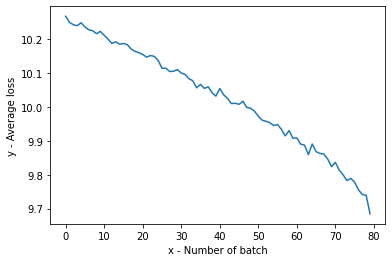

In [15]:
plt.plot(full_losses)

# naming the x axis
plt.xlabel('x - Number of batch')
# naming the y axis
plt.ylabel('y - Average loss')
  

# Check forward LSTM model

In [16]:
file = "2head.txt"
dataset = LazyTextDataset(datafolder + file, sentence_length, skipsos, jagged, bid, delimiter)
model.eval()
test_input = torch.unsqueeze(dataset[1]['x'], dim=0)
if cuda:
    test_input = test_input.cuda()
output, lstm_out, hx = model(test_input)
print(f"Ground truth: {dataset[1]['t']}")
print(f'Model prediction: {torch.argmax(output, dim=2)}')

Ground truth: tensor([ 4, 23,  4, 14, 14,  6, 16, 21,  9,  1])
Model prediction: tensor([[ 1819,    84,   229,    84,   303, 17356,     1,   530,   530,     1]])


# Train the tiered model

In [17]:
context_size = [10]
layer_list = [5] #hidden units of each layer.
num_steps = 3
model = Tiered_LSTM(layer_list, context_size, vocab_size, embedding_dim, context_size[0], jagged = False, bid = False)
data_handler = OnlineLMBatcher(datafolder + files[0], conf, context_size, skipsos, jagged, bid, batch_size=64, num_steps=num_steps, delimiter=" ", skiprows=0)
criterion = nn.CrossEntropyLoss(reduction= 'none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 20, gamma=0.99)
early_stopping = EarlyStopping(patience=patience, verbose=True)

In [18]:
train_tiered(model, criterion, optimizer, scheduler, early_stopping, data_handler, cuda, jagged, epochs=1)

Validation loss decreased (inf --> 30.887043).  Saving model ...
Validation loss decreased (30.887043 --> 30.862492).  Saving model ...
Validation loss decreased (30.862492 --> 30.834791).  Saving model ...
Validation loss decreased (30.834791 --> 30.819456).  Saving model ...
Validation loss decreased (30.819456 --> 30.793690).  Saving model ...
Validation loss decreased (30.793690 --> 30.762918).  Saving model ...
Validation loss decreased (30.762918 --> 30.725296).  Saving model ...
Validation loss decreased (30.725296 --> 30.714081).  Saving model ...
Validation loss decreased (30.714081 --> 30.693302).  Saving model ...
Validation loss decreased (30.693302 --> 30.670261).  Saving model ...
Validation loss decreased (30.670261 --> 30.660814).  Saving model ...
Validation loss decreased (30.660814 --> 30.571449).  Saving model ...
Validation loss decreased (30.571449 --> 30.548882).  Saving model ...
Validation loss decreased (30.548882 --> 30.536812).  Saving model ...
Validation l

### (By overfitting LSTM model on a small dataset, let me check whether the model has ability to learn the relation between input and output)

In [19]:
# mb_size = 1
test_batch_size = 1
sos = torch.zeros(mb_size * test_batch_size, 1, dtype=torch.long)
eos = torch.ones(mb_size * test_batch_size, 1, dtype=torch.long)
ex_sentences = torch.LongTensor(mb_size * test_batch_size, conf['sentence_length']-2 ).random_(0, vocab_size)
example_sentences = torch.cat((sos, ex_sentences, eos), axis=1)

startx = int(skipsos)+ int(jagged)
startt = int(skipsos)+ int(jagged) + 1
endx = example_sentences.shape[1]- int(not(bid))
endt = example_sentences.shape[1] - int(bid)

input_sentences = np.split(example_sentences[:,startx:endx], test_batch_size)
output_sentences = np.split(example_sentences[:,startt:endt], test_batch_size)
data = []

for x, t in zip(input_sentences, output_sentences):
    tmp_dict={}
    tmp_dict['x'] = x
    tmp_dict['t'] = t
    data.append(tmp_dict)

In [20]:
%%time
model = Fwd_LSTM(layer_list, vocab_size, embedding_dim) #For bidirectional LSTM bid_LSTM(layer_list, vocab_size, embedding_dim)
if cuda:
    model.cuda()
criterion = nn.CrossEntropyLoss(reduction = 'none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 20, gamma=1)
early_stopping = EarlyStopping(patience=patience, verbose=False)
epochs = 3000
model, train_losses = train_model(model, criterion, optimizer, scheduler, early_stopping, data, cuda, jagged, epochs)

0th epoch loss: 10.267622947692871
500th epoch loss: 6.830822467803955
1000th epoch loss: 5.730741024017334
1500th epoch loss: 5.094110012054443
2000th epoch loss: 4.64980936050415
2500th epoch loss: 4.304615020751953
CPU times: user 49min 31s, sys: 18min 3s, total: 1h 7min 34s
Wall time: 31min 5s


Text(0, 0.5, 'y - Average loss')

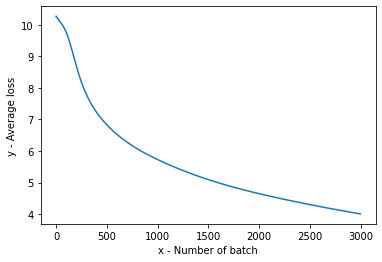

In [21]:
plt.plot(train_losses)

# naming the x axis
plt.xlabel('x - Number of batch')
# naming the y axis
plt.ylabel('y - Average loss')
  

In [22]:
test_input = data[0]['x']
if cuda:
    test_input = test_input.cuda()
output, lstm_out, hx = model(test_input[:5,:])
print(f"Ground truth: \n {data[0]['t'][:5,:]}")
print(f'Model prediction: \n {torch.argmax(output, dim=2)}')

Ground truth: 
 tensor([[21348, 23271,  9777, 10794, 20819, 21461, 10261, 18006, 26942,     1],
        [16986,  9585, 26224,  6343, 14685, 14458,  7014,  2104,  8851,     1],
        [ 5455, 21333, 19518, 16742,  8826, 11628, 25545, 15454,  9366,     1],
        [20787, 23147,  5041, 27811, 14159,  5125, 14308, 12235,  9412,     1],
        [24634, 25814, 16463,  8804,  2954, 15159, 27832,  5075, 15858,     1]])
Model prediction: 
 tensor([[ 8039,  8039,  8039,  8039,  8039,  8039,  8039, 14326,     1,     1],
        [11509,  9585,   269,     1,     1,     1, 14326, 13434,  8456,     1],
        [12355, 23564, 27811, 20540, 20540, 20147,  9901,  5851,     1,     1],
        [ 4089, 11509, 12355,     1,     1,     1,     1,     1,     1,     1],
        [23948,  4089,     1,     1,     1,  8039, 10580, 10580,     1,     1]])
